In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os, sys, math, random
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import numpy as np
import kornia
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
from pytorch_pretrained_biggan import BigGAN, convert_to_images, save_as_images
from pathlib import Path
from datetime import datetime
import random

from src.notebook_utils import imshow, imgrid, pltshow, draw_tensors
from src.face_loss import DlibFaceLoss
from src.pytorch_utils import augment
from src.palette import random_biggan, load_directory, load_images
from src.collage import Collager
from src.collage_save import CollageSaver

In [4]:
img_size = 512

# Mask generator

In [5]:
from src.gan import Generator
mask_generator = Generator(img_size=128, latent_size=100, channels=1).cuda()
model_path = '/home/joel/Projects/FormsOfLife/saved_models/dcgan_gen_128'
# model_path = './saved_models/dcgan_gen_r128_z100'
mask_generator.load_state_dict(torch.load(model_path))
mask_generator.eval()
None

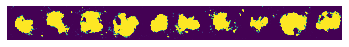

In [6]:
masks = mask_generator(torch.randn(10, 100).cuda())
pltshow(np.hstack(masks[:, 0].detach().cpu().numpy()))

# Make or load the palette

In [28]:
USE_BIGGAN = False
if USE_BIGGAN:
    n_refs = 24*2
    biggan = BigGAN.from_pretrained(f'biggan-deep-{img_size}').cuda()
    palette = random_biggan(n_refs, img_size, biggan, seed=1, truncation=.4)
else:
#     palette_imgs_large = torch.cat([
#        load_directory('./datasets/eyes_closed/', 1024),
#        load_directory('./datasets/artbreeder/', img_size)
#     ])
    img_names = [
        './datasets/ab_biggan/2db513d411406270f1ee_hires.jpeg',
        './datasets/ab_biggan/2012fae76a825b03405d8f46_hires.jpeg'
    ]
    palette_imgs_large = load_images(img_names, 1024)
    palette_imgs = F.interpolate(palette_imgs_large, size=(img_size, img_size), mode='bilinear')

In [29]:
patch_per_img = 6

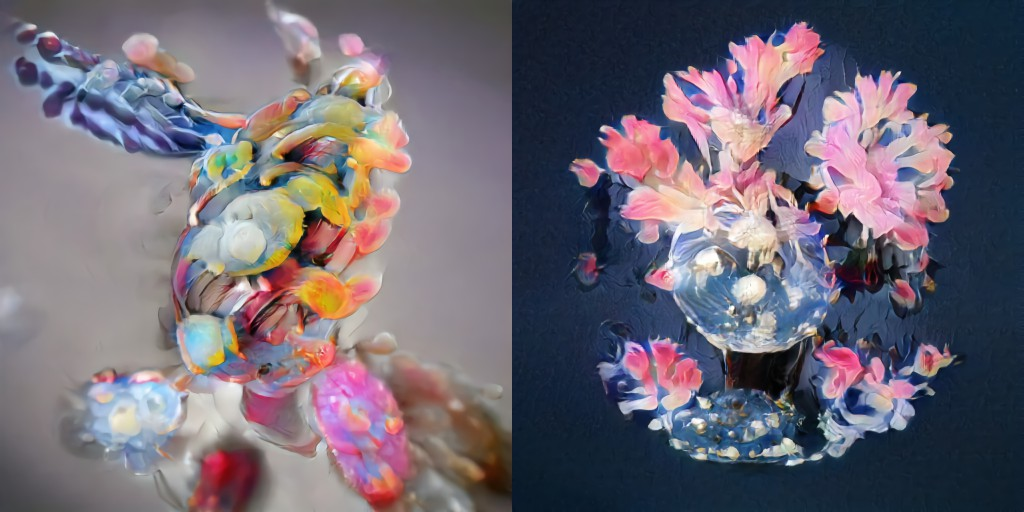

In [30]:
draw_tensors(palette_imgs)

In [31]:
collager = Collager(palette_imgs, mask_generator, img_size, patch_per_img)

# View Random

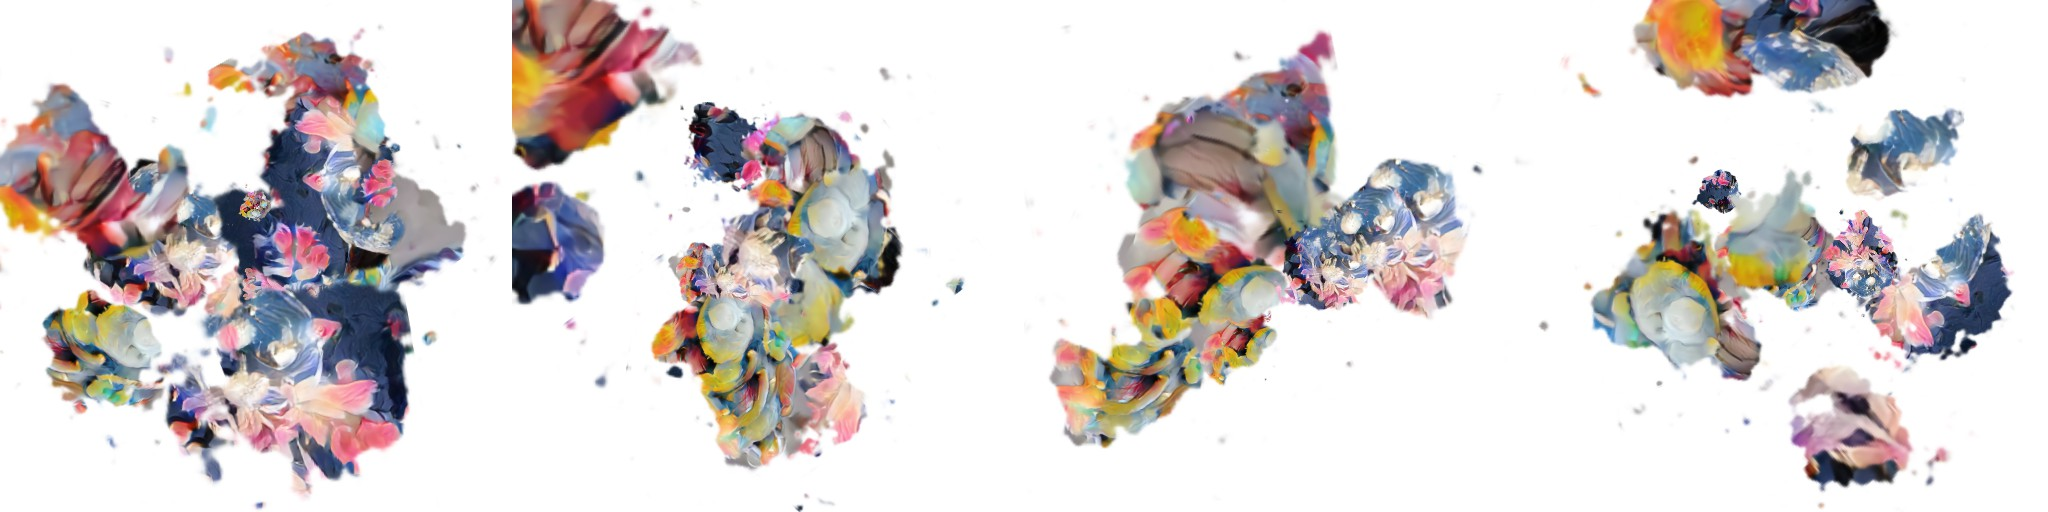

In [32]:
with torch.no_grad():
    imgs = [ collager(*collager.makeRandom(seed=i)) for i in range(4) ] 
    draw_tensors(torch.stack(imgs).squeeze())

# Loss functions

In [33]:
face_loss = DlibFaceLoss(filter_index=1)
# identity_loss = IdentityLoss('./dataset/matisse')
# disc_loss = DiscriminatorLoss()
def entropy_loss(x):
    return -x.mul(x.log2()).sum()

def tv_loss(t):
    return (torch.mean(torch.abs(t[:, :, :-1] - t[:,  :, 1:])) +
            torch.mean(torch.abs(t[:,  :-1, :] - t[:, 1:, :])))

# Optimization

results/2020-10-05-23-51-tekenf


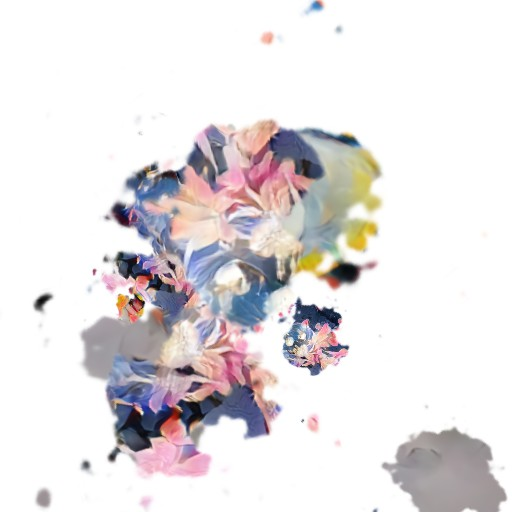

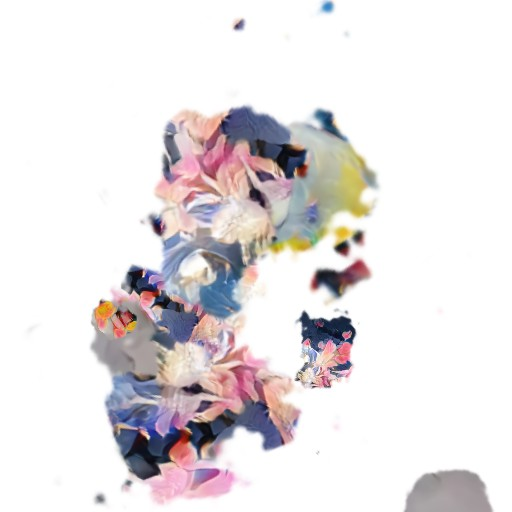

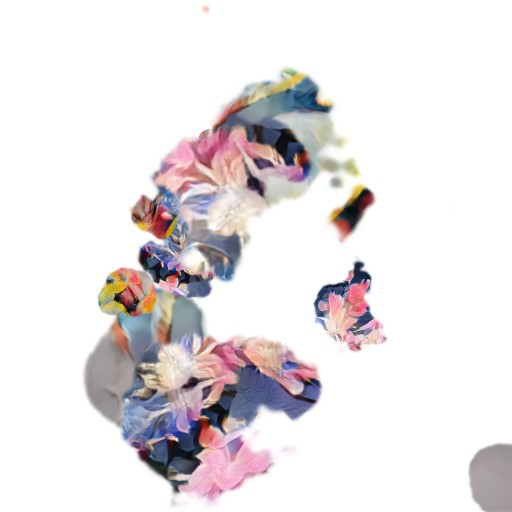

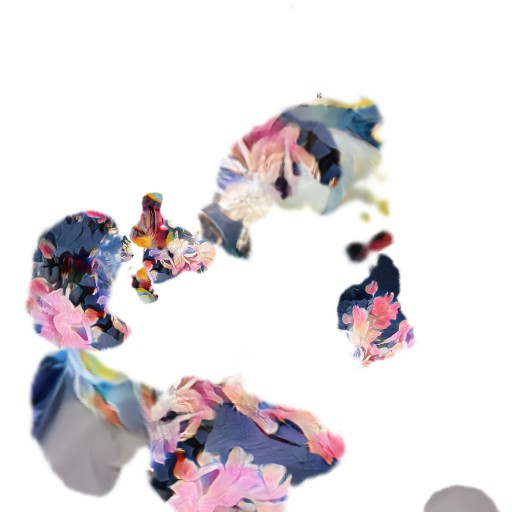

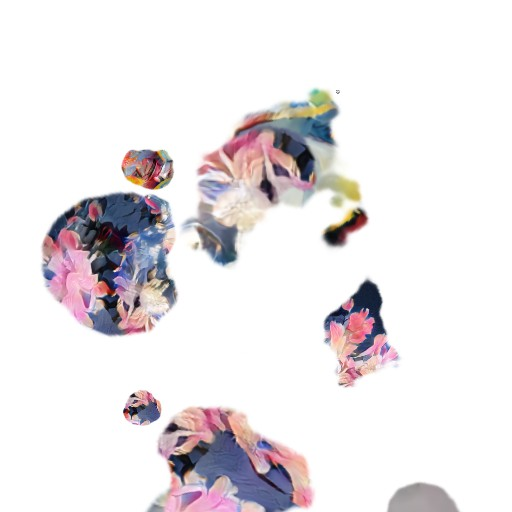

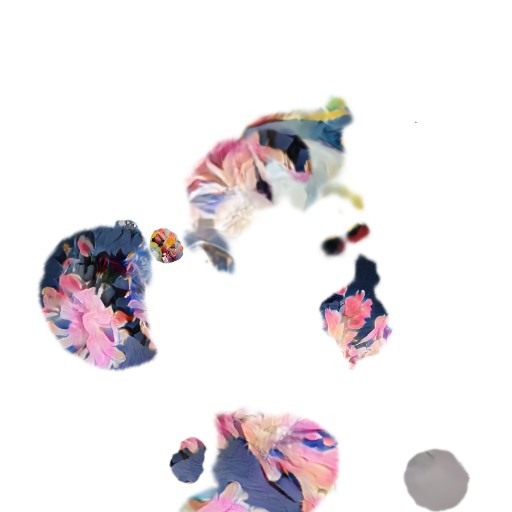

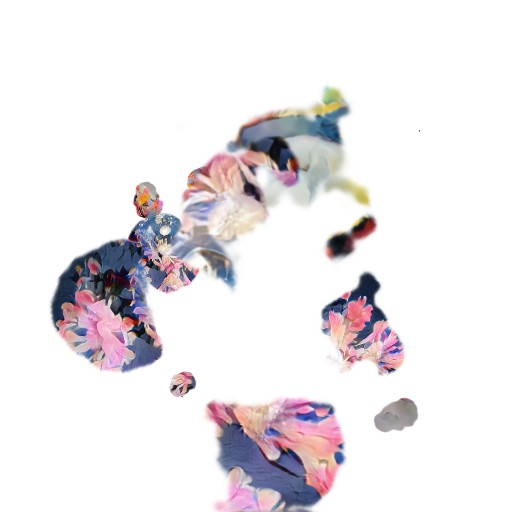

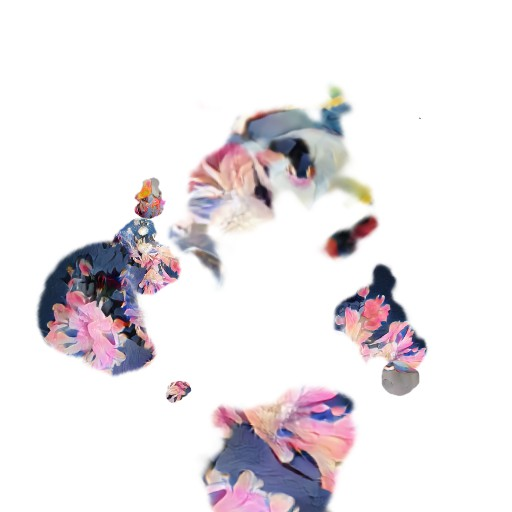

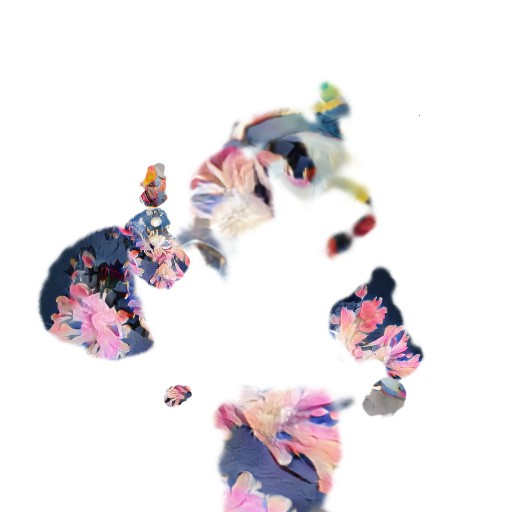

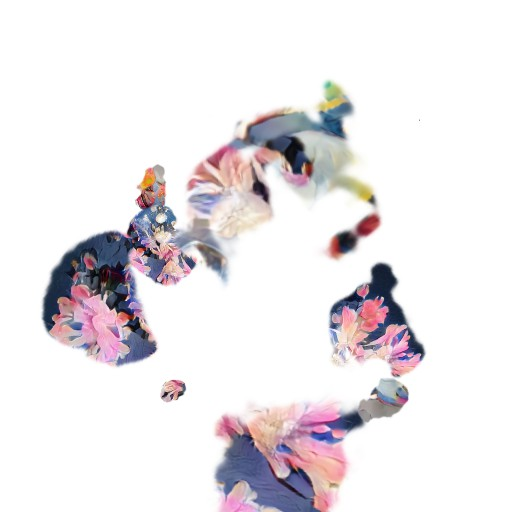

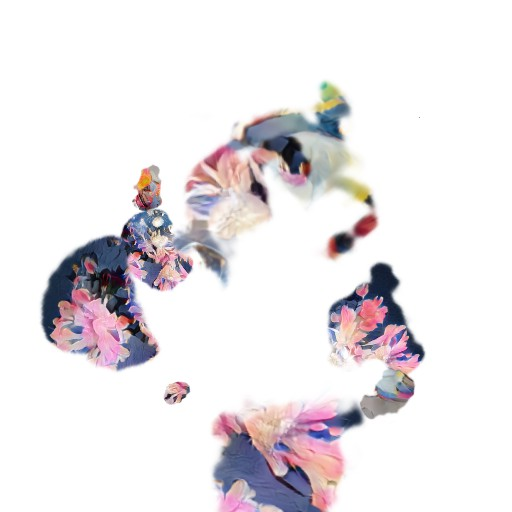

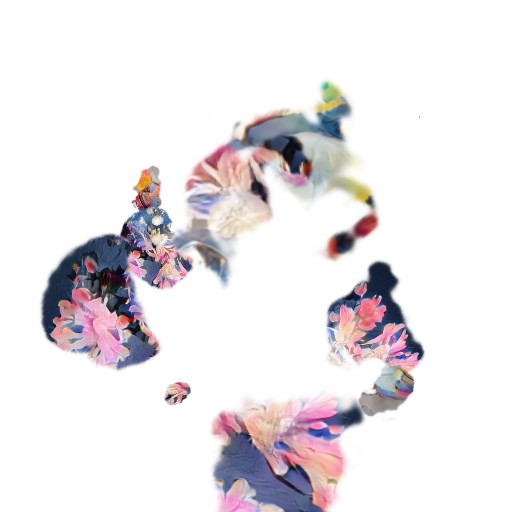

In [34]:
n_steps=600
seed=None

if seed is not None:
    torch.random.manual_seed(seed)

saver = CollageSaver()
saver.save_palette(palette_imgs)
print(saver.path)

save_every_step = False
lr=5e-2
frames = []

collage_data = collager.makeRandom(seed=seed)
params = collage_data
Z = collage_data[0]

for x in collage_data:
    x.requires_grad_(True)

opt = torch.optim.Adam(params, lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, total_steps=n_steps)

pbar = tqdm(total=n_steps)
loss_history = []

for i in range(n_steps):
    percent = i / n_steps
    pbar.update()        
    opt.zero_grad()
    fl = torch.zeros(1)
    norm_loss = .25 * Z.norm()
    img = collager(*collage_data)
    aug = augment(img, n=3)
    fl = face_loss(((aug+1)*.5)).mean()
    loss = fl + norm_loss #- .0001*img.mean()
    loss_history.append(loss.detach().cpu().item())
    loss.backward(retain_graph=True)
    #loss.backward()
    opt.step()
    scheduler.step()
#     if save_every_step:
#         saver.save_canvas(i, img)
#         saver.save_masks(i, masks, masks_trans, M)
#         saver.save_lookup_table(i, piece_lookup)
    pbar.set_description(f"fl: {fl.item():.3f}")
    frames.append(
        np.array(convert_to_images(img.detach().cpu())[0])
    )
    if i % 50 == 0 and i > 0 or i == n_steps-1:
        draw_tensors(img)

In [36]:
print(saver.path)

results/2020-10-05-23-51-tekenf


# Export video, highres image and masks

In [37]:
saver.save_video(frames)

In [38]:
from src.collage_save import CollageSaver
export_collager = Collager(palette_imgs_large, mask_generator, 1024, patch_per_img)
with torch.no_grad():
    collage, lut, masks, masks_palette = export_collager(*collage_data, return_data=True)
    saver.save_canvas_final(img)
    saver.save_lookup_table_final(lut)
    saver.save_masks_final(masks, masks_palette)

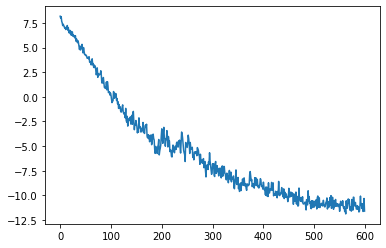

In [39]:
opt_img, opt_collage_data, opt_history = \
    img.detach(), tuple(x.detach() for x in collage_data), loss_history
_= plt.plot(opt_history)